### Defocused probe ptychography

In this tutorial notebook, we will perform both differential phase contrast (DPC) and ptychographic phase reconstructions from a simulated 4D-STEM dataset.

### Downloads

* [4D-STEM dataset](https://drive.google.com/file/d/1uyeQAQa4DaMwHqN9EHQFCMKAve0_Fgfz/view?usp=share_link)
* [vacuum probe intensity](https://drive.google.com/file/d/1xJgQoxhWMBbtknwRfqB_BkULvgiJe-c1/view?usp=share_link)

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Colin Ophus (clophus@lbl.gov)
- Stephanie Ribet (sribet@u.northwestern.edu)
- Georgios Varnavides (gvarnavides@berkeley.edu)

The 4D-STEM dataset used here was simulated by Colin Ophus using the reference implementation of partitioned PRISM which can be found at the [Github repo for superPRISM](https://github.com/cophus/superPRISM). We have also added the common experiment artifacts of probe descan which varies over the field of view and shot noise.

Updated 2023 Mar 31

In [1]:
import numpy as np
import py4DSTEM
print(py4DSTEM.__version__)

0.13.14


In [2]:
#file_path = 'C:/data/4DSTEM/tutorial/'
file_path = 'data/'
file_data = file_path + 'ptycho_sim_01_data.h5'
file_probe = file_path + 'ptycho_sim_01_probe.h5'
file_analysis = file_path + 'analysis_'

### load the data

In [3]:
dataset = py4DSTEM.read(file_data)
dataset

DataCube( A 4-dimensional array of shape (32, 32, 200, 200) called 'datacube',
          with dimensions:

              Rx = [0,1,...] pixels
              Ry = [0,1,...] pixels
              Qx = [0,1,...] pixels
              Qy = [0,1,...] pixels

In [4]:
probe = py4DSTEM.read(file_probe)
probe

DiffractionSlice( A 2-dimensional array of shape (200, 200) called 'diffractionslice',
                  with dimensions:

                      dim0 = [0,1,...] pixels
                      dim1 = [0,1,...] pixels

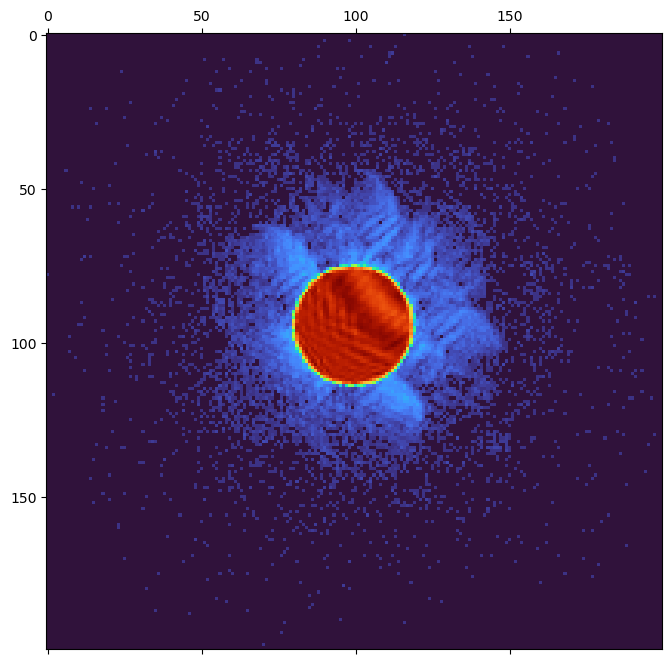

In [5]:
# Let's plot some of the probe positions:
py4DSTEM.show(
    dataset.data[11,24],
    cmap='turbo',
    vmax=1,
    power=0.333,
)

### Calibration

In [6]:
# calibrations - we will manually enter the diffraction space sampling, 
# and the real space step size between adjacent STEM probes:
dataset.calibration.set_Q_pixel_size(0.025)
dataset.calibration.set_Q_pixel_units('A^-1')
dataset.calibration.set_R_pixel_size(5.0)
dataset.calibration.set_R_pixel_units('A')

# DPC

Best fit rotation = -15.0 degrees.
No need to transpose diffraction intensities.


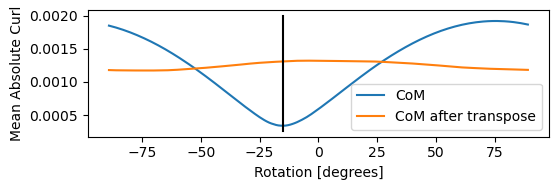

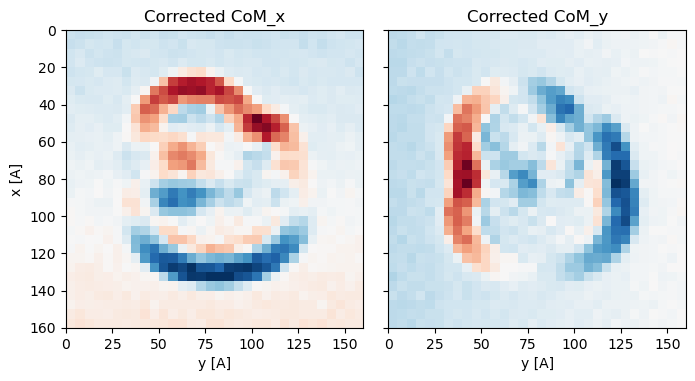

In [7]:
# First, we perform the preprocessing steps. These include:
# 1 - measuring the center of mass (CoM) for all probe postions.
# 2 - fitting the probe descan to a plane wave or another function.
# 3 - determining the best-fit rotation between real and reciprocal space.
# 4 - calculating the corrected CoM images.
dpc = py4DSTEM.process.phase.DPCReconstruction(
    dataset,
    energy=80e3,
).preprocess()

Reconstructing phase:  84%|█████████████████████████████████████████████████████████████████▊            | 27/32 [00:00<00:00, 1664.68 iter/s]
/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_dpc.py:514: UserWarning: Step-size has decreased below stopping criterion 1e-06.
  warnings.warn(


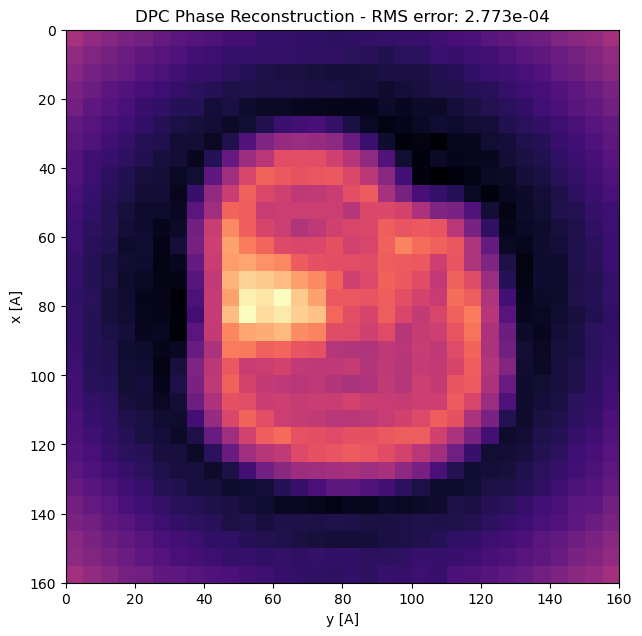

In [8]:
# Next we perform the DPC reconstruction:
dpc = dpc.reconstruct(
    progress_bar=True,
    store_iterations=True,
    max_iter=32
).visualize()

The reconsruction clearly shows the object on the substrate. However, the resolution is limited to the STEM probe sampling - we only recover one phase value per probe position. In order to perform superresolution imaging (i.e. recover spatial frequencies outside of the numerical aperture / probe semiangle), we will need to peform a ptychographic reconstruction.

# Ptychography

Best fit rotation = -15.0 degrees.
No need to transpose diffraction intensities.


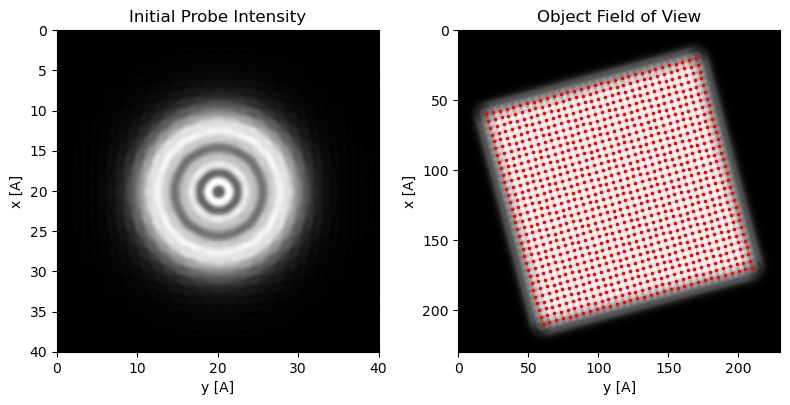

In [9]:
# We perform very similar pre-processing for ptychography as we do for DPC.
# Getting a good guess for the rotation between real space and diffraction space
# is essential to getting a good reconstruction in defocused probe ptychography.
ptycho = py4DSTEM.process.phase.PtychographicReconstruction(
    dataset,
    verbose=True,
    energy=80e3,
    defocus=600,
    vacuum_probe_intensity = probe.data,
    #semiangle_cutoff = 20,
).preprocess(
    plot_center_of_mass = False,
    plot_rotation = False,
    plot_probe_overlaps = True,
)

In [10]:
# import numpy as np
# py4DSTEM.show([
#     np.fft.fftshift(np.abs(np.fft.fft2(ptycho._probe))),
#     dataset.get_dp_mean()
#     ],
#     vmax = 1,
# )

Performing 8 iterations using the gradient-descent algorithm, with normalization_min: 0.1.


Reconstructing object and probe: 100%|███████████████████████████████████████████████████████████████████████| 8/8 [01:07<00:00,  8.45s/ iter]


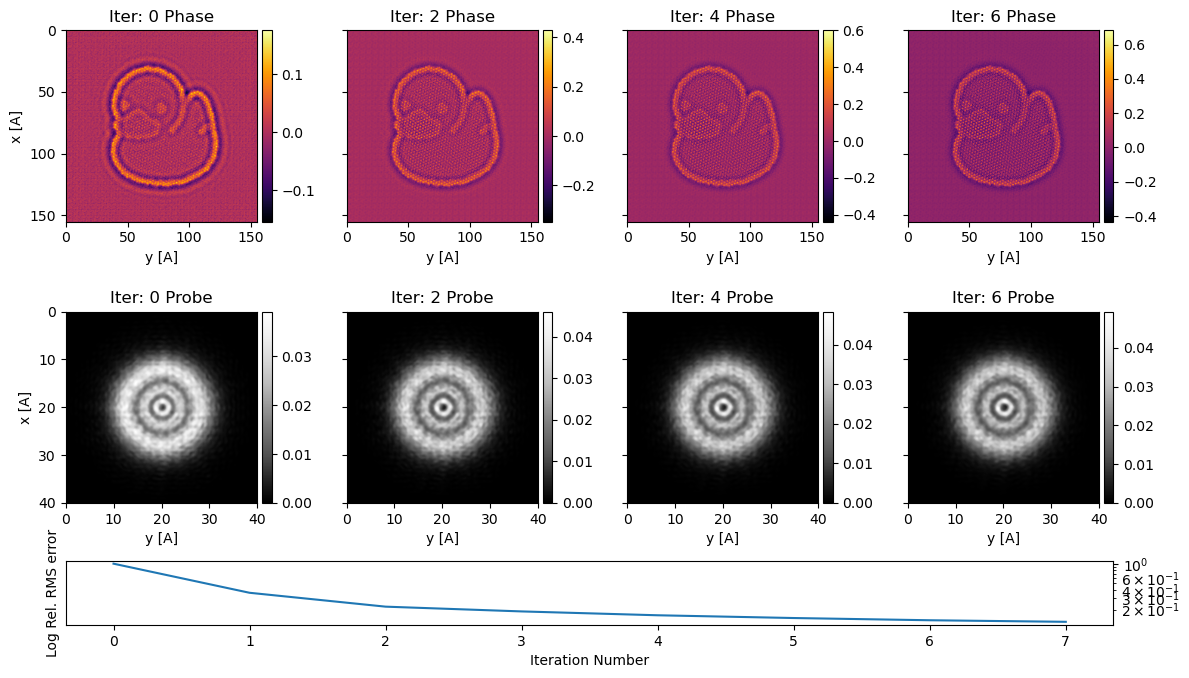

In [10]:
# Next, we perform the ptychographic reconstruction.  There are various options we can tune
# below, but this reconstruction converges quite rapidly due to the sample being close to a 
# weak phase object (the thickest region of the sample consists of 4 graphene layers).
ptycho = ptycho.reconstruct(
    progress_bar = True,
    store_iterations = True,
    max_iter = 8,
    step_size=0.95,
    normalization_min=0.1
).visualize(
    cbar=True,
    iterations_grid='auto',
    plot_convergence=True,
    plot_probe=True,
    object_mode='phase',
)

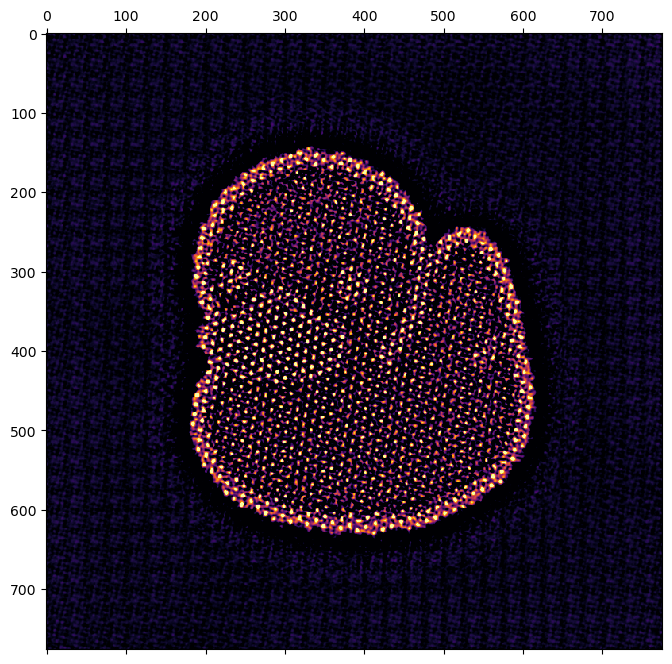

In [11]:
# We then plot the final reconstructed phase:
py4DSTEM.show(
    ptycho._crop_rotate_object_fov(
        np.angle(ptycho.object)
    ),
    vmin=0.3,
    vmax=0.99,
    cmap='inferno',
)